In [1]:
# stock predictor using dual moving average crossover method
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

plt.style.use('fivethirtyeight')

In [2]:
# load data
df_sp500 = pd.read_csv('sp500_20210219.csv') #, index_col='Date')
df_sp500.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
df_sp500.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23395 entries, 0 to 23394
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       23395 non-null  object 
 1   Open       23395 non-null  float64
 2   High       23395 non-null  float64
 3   Low        23395 non-null  float64
 4   Close      23395 non-null  float64
 5   Adj_Close  23395 non-null  float64
 6   Volume     23395 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.2+ MB


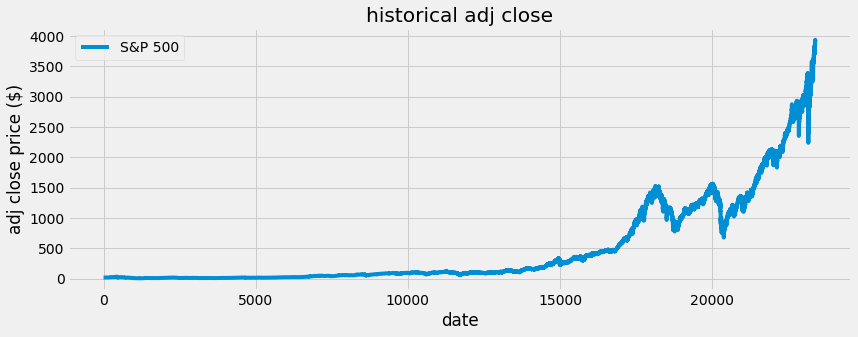

In [3]:
# visualize
plt.figure(figsize=(12.5, 4.5))
plt.plot(df_sp500['Adj_Close'], label='S&P 500')
plt.title('historical adj close')
plt.xlabel('date')
plt.ylabel('adj close price ($)')
plt.legend(loc='upper left')
plt.show()

In [4]:
# create simple moving avg with a 30 day window
sma30 = pd.DataFrame()
sma30['Adj_Close'] = df_sp500['Adj_Close'].rolling(window=30).mean()


In [5]:
# create a simple 100 day avg
sma100 = pd.DataFrame()
sma100['Adj_Close'] = df_sp500['Adj_Close'].rolling(window=100).mean()

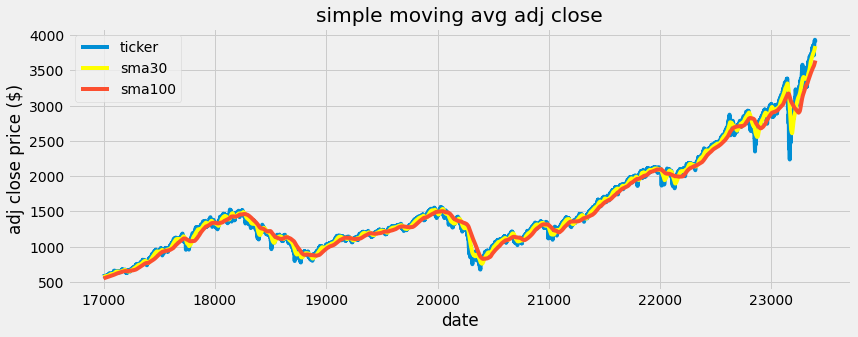

In [6]:
# visualize data
plt.figure(figsize=(12.5, 4.5))
plt.plot(df_sp500.loc[17_000:, 'Adj_Close'], label='ticker')
plt.plot(sma30.loc[17_000:, 'Adj_Close'], label= 'sma30', color='yellow')
plt.plot(sma100.loc[17_000:, 'Adj_Close'], label= 'sma100')
plt.title('simple moving avg adj close')
plt.xlabel('date')
plt.ylabel('adj close price ($)')
plt.legend(loc='upper left')
plt.show()


In [7]:
# create a new dataframe
df_sma = pd.DataFrame()
df_sma['sp500'] = df_sp500['Adj_Close']
df_sma['sma30'] = sma30['Adj_Close']
df_sma['sma100'] = sma100['Adj_Close']
df_sma

,sp500,sma30,sma100
0,17.660000,NaN,NaN
1,17.760000,NaN,NaN
2,17.719999,NaN,NaN
3,17.549999,NaN,NaN
4,17.660000,NaN,NaN
...,...,...,...
23390,3934.830078,3820.470345,3614.937202
23391,3932.590088,3826.354346,3621.107402
23392,3931.330078,3834.043685,3628.051504
23393,3913.969971,3840.280680,3634.725303


In [8]:
df_sma.dropna(inplace=True)
df_sma.reset_index(drop=True, inplace=True)


In [9]:
df_sma

,sp500,sma30,sma100
0,19.750000,19.813000,18.442200
1,19.870001,19.828333,18.464300
2,19.900000,19.834000,18.485700
3,19.570000,19.830333,18.504200
4,19.820000,19.840333,18.526900
...,...,...,...
23291,3934.830078,3820.470345,3614.937202
23292,3932.590088,3826.354346,3621.107402
23293,3931.330078,3834.043685,3628.051504
23294,3913.969971,3840.280680,3634.725303


In [10]:
# create function when to buy and sell
def buy_sell(data):
    sig_buy = []
    sig_sell = []
    flag = -1

    for i in range(len(data)):
        if data.loc[i, 'sma30'] > data.loc[i, 'sma100']:
            if flag != 1:
                sig_buy.append(data.loc[i, 'sp500'])
                sig_sell.append(np.nan)
                flag = 1
            else:
                sig_buy.append(np.nan)
                sig_sell.append(np.nan)
        elif data.loc[i, 'sma30'] < data.loc[i, 'sma100']:
            if flag != 0:
                sig_buy.append(np.nan)
                sig_sell.append(data.loc[i, 'sp500'])
                flag = 0
            else:
                sig_buy.append(np.nan)
                sig_sell.append(np.nan)
        else:
            sig_buy.append(np.nan)
            sig_sell.append(np.nan)

    return(sig_buy, sig_sell)


In [11]:
# store returned result
action = buy_sell(df_sma)
df_sma['Buy_Signal_Price'] = action[0]
df_sma['Sell_Signal_Price'] = action[1]


In [12]:
# show data
df_sma

,sp500,sma30,sma100,Buy_Signal_Price,Sell_Signal_Price
0,19.750000,19.813000,18.442200,19.75,NaN
1,19.870001,19.828333,18.464300,NaN,NaN
2,19.900000,19.834000,18.485700,NaN,NaN
3,19.570000,19.830333,18.504200,NaN,NaN
4,19.820000,19.840333,18.526900,NaN,NaN
...,...,...,...,...,...
23291,3934.830078,3820.470345,3614.937202,NaN,NaN
23292,3932.590088,3826.354346,3621.107402,NaN,NaN
23293,3931.330078,3834.043685,3628.051504,NaN,NaN
23294,3913.969971,3840.280680,3634.725303,NaN,NaN


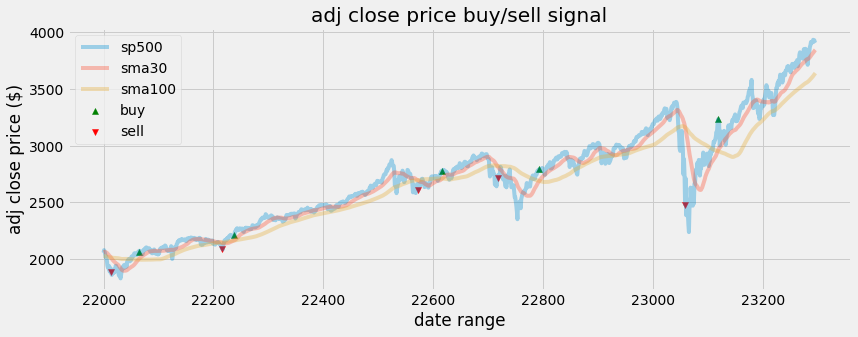

In [13]:
# visualize data
start = 22_000
plt.figure(figsize=(12.5, 4.5))
plt.plot(df_sma.loc[start:, 'sp500'], label='sp500', alpha=0.35)
plt.plot(df_sma.loc[start:, 'sma30'], label='sma30', alpha=0.35)
plt.plot(df_sma.loc[start:, 'sma100'], label='sma100', alpha=0.35)
plt.scatter(df_sma.index[start:], df_sma.loc[start:, 'Buy_Signal_Price'], label='buy', marker='^', color='green')
plt.scatter(df_sma.index[start:], df_sma.loc[start:, 'Sell_Signal_Price'], label='sell', marker='v', color='red')
plt.title('adj close price buy/sell signal')
plt.xlabel('date range')
plt.ylabel('adj close price ($)')
plt.legend(loc='upper left')
plt.show()
